In [2]:
# Libraries for general data management
import pandas as pd
import numpy  as np
np.seterr(divide = 'ignore') 

# Libraries for creating and validating models
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_val_score

# Libraries for data visualization
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches
import seaborn as sns
plt.rc("figure", figsize=(14,7))
plt.rc("font", size=12)

# Libraries for data modeling
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Library for iterations
from itertools import combinations

# Helper functions
from lc3_implementations import *

import warnings
warnings.filterwarnings('ignore')

# Input file path (can be also an excel)
DATA_PATH = './data/data_merged.ods'

In [3]:
data = pd.read_excel(DATA_PATH, skiprows=[0], na_values=['-'])

In [4]:
rename_std_cols(data)
data

,Clay,day_1,STD_1D,day_3,STD_3D,day_7,STD_7D,day_28,STD_28D,day_90,...,CaO,MgO,SO3,Na2O,K2O,TiO2,P2O5,MnO,Others,LOI
0,B45 Quartz B250,7.808750,0.251891,18.683750,0.328841,26.073438,0.696464,29.168750,0.541867,30.062500,...,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN,NaN,0.1
1,B45 India3 750°C,9.403125,0.189520,21.560417,1.963092,29.157500,0.868001,37.515625,0.555407,40.345312,...,0.6,0.7,NaN,0.1,2.3,0.8,0.1,0.1,0.2,0.5
2,B45 Brazil2,9.856250,0.306569,24.558750,0.830034,39.638750,0.894552,46.975000,0.501482,47.657812,...,0.5,NaN,NaN,NaN,0.3,1.5,NaN,NaN,NaN,1.4
3,B45 Thailand 750°C,10.083750,0.133507,25.482500,0.695962,41.887500,1.548966,54.911250,2.384772,58.546250,...,1.3,0.8,0.1,0.4,0.2,2.4,0.4,0.1,0.2,1.7
4,B45 Suriname1,12.016250,0.357853,32.342188,1.288414,45.941250,2.145351,55.303750,1.330976,58.403750,...,NaN,NaN,NaN,NaN,0.1,1.8,0.1,NaN,0.2,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,Guinea 1,9.743750,0.345111,19.531250,0.318934,29.687500,0.617549,36.325524,0.495647,35.692986,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,Guinea 2,9.879167,0.177805,23.562500,0.169097,39.754167,0.459379,49.799855,0.231454,50.441401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,Guinea 3,9.547917,0.432125,20.972917,0.713002,31.252083,1.274852,40.616903,0.827480,42.787325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,Nigeria,9.866667,0.069128,23.820833,0.307734,39.408333,1.033659,51.801268,1.122305,50.512995,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data_d1 = data[["Kaolinite_content", "day_1", "STD_1D"]]
data_d1.dropna()

x = data_d1[["Kaolinite_content"]].values
X = sm.add_constant(x, has_constant='skip')
Y1  = data_d1[["day_1"]].values

# Compute weights
std = data_d1["STD_1D"].values
norm_std = (std-std.min())/(std.max()-std.min())
norm_std[norm_std==0] = 1e-4
    
# weights1 = 1./(norm_std**2); We can simplify and use 1/std [2]
weights1 = 1./norm_std

mod_wls = sm.WLS(Y1, X, weights=weights1)
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.344
Model:                            WLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     33.59
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           2.26e-07
Time:                        04:23:06   Log-Likelihood:                -136.12
No. Observations:                  66   AIC:                             276.2
Df Residuals:                      64   BIC:                             280.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7389      0.362     26.939      0.0

parameters OLS vs. WLS
[8.1820788  0.06610393]
[9.73889731 0.02964215]


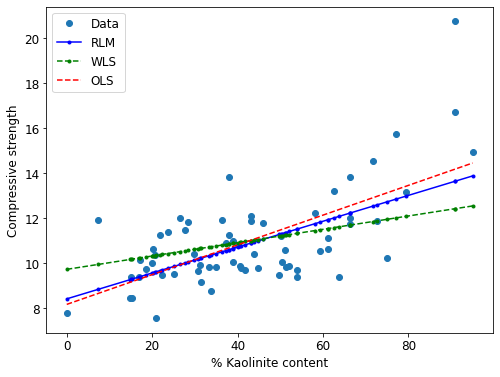

In [5]:
# plot WLS
prstd, iv_l, iv_u = wls_prediction_std(res_wls)

fig, ax = plt.subplots(figsize=(8,6))

#Datapoints
ax.plot(x, Y1, 'o', label="Data")

# RLM (robust linear models) prediction
resrlm = sm.RLM(Y1, X).fit()
ax.plot(x, resrlm.fittedvalues, 'b.-', label="RLM")

# WLS (weighted least squares) prediction
ax.plot(x, res_wls.fittedvalues, 'g--.', label="WLS")
#ax.plot(X, iv_u, 'g--')
#ax.plot(X, iv_l, 'g--')
ax.set_xlabel('% Kaolinite content')
ax.set_ylabel('Compressive strength')

# OLS (ordinary least squares) prediction
res_ols = sm.OLS(Y1, X).fit()
print("======================")
print("parameters OLS vs. WLS")
print("======================")
print(res_ols.params)
print(res_wls.params)

# Calculate prediction interval
tppf = stats.t.ppf(0.975, res_ols.df_resid)
prstd_ols, iv_l_ols, iv_u_ols = wls_prediction_std(res_ols)

ax.plot(x, res_ols.fittedvalues, 'r--', label="OLS")
# ax.plot(X, iv_u_ols, 'r--')
# ax.plot(X, iv_l_ols, 'r--')

ax.legend(loc="best");

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.344
Model:                            WLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     33.59
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           2.26e-07
Time:                        04:14:59   Log-Likelihood:                -136.12
No. Observations:                  66   AIC:                             276.2
Df Residuals:                      64   BIC:                             280.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7389      0.362     26.939      0.0

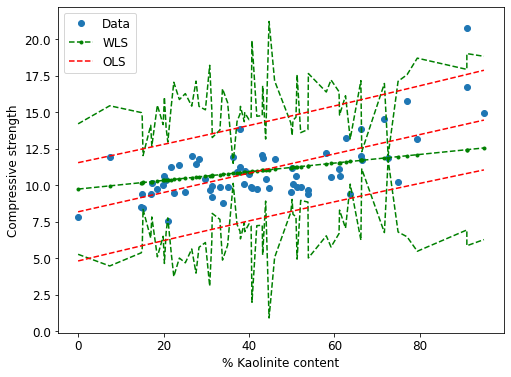

(<statsmodels.regression.linear_model.WLS at 0x7fca63d63b80>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fca63f8e430>)

In [6]:
compute_WLS_model(data,1, summary=True, plot=True, show_bounds=True, show_ols=True)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.344
Model:                            WLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     33.59
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           2.26e-07
Time:                        04:15:00   Log-Likelihood:                -136.12
No. Observations:                  66   AIC:                             276.2
Df Residuals:                      64   BIC:                             280.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7389      0.362     26.939      0.0

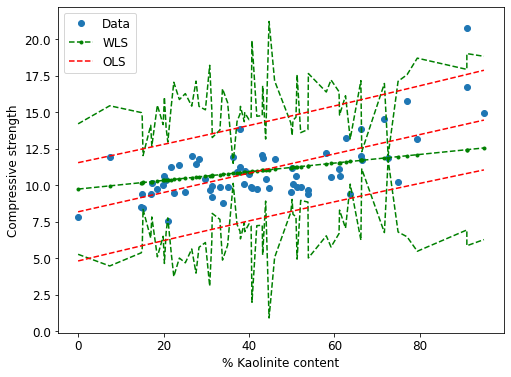

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.766
Model:                            WLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     209.9
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           7.07e-22
Time:                        04:15:00   Log-Likelihood:                -194.96
No. Observations:                  66   AIC:                             393.9
Df Residuals:                      64   BIC:                             398.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.0104      0.642     26.482      0.0

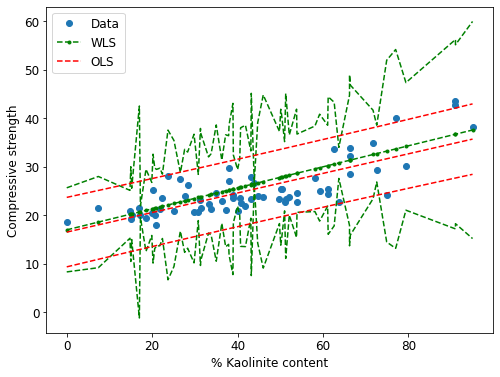

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.942
Model:                            WLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1031.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           3.51e-41
Time:                        04:15:00   Log-Likelihood:                -172.88
No. Observations:                  66   AIC:                             349.8
Df Residuals:                      64   BIC:                             354.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.3194      0.176    149.332      0.0

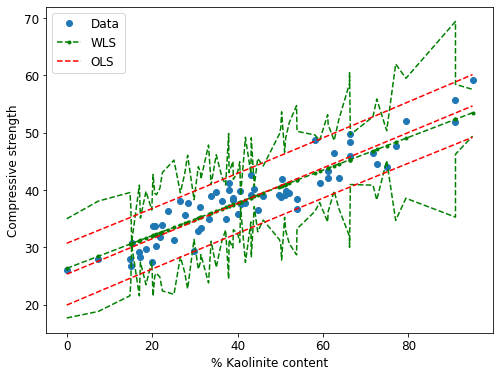

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.926
Model:                            WLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     797.3
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           7.68e-38
Time:                        04:15:01   Log-Likelihood:                -194.75
No. Observations:                  66   AIC:                             393.5
Df Residuals:                      64   BIC:                             397.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.0278      0.361     83.065      0.0

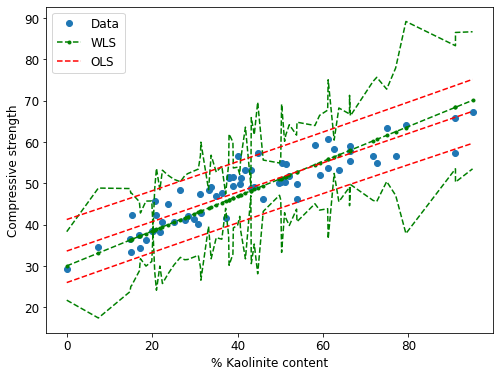

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            WLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1487.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           1.85e-40
Time:                        04:15:01   Log-Likelihood:                -156.56
No. Observations:                  55   AIC:                             317.1
Df Residuals:                      53   BIC:                             321.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.7903      0.160    205.104      0.0

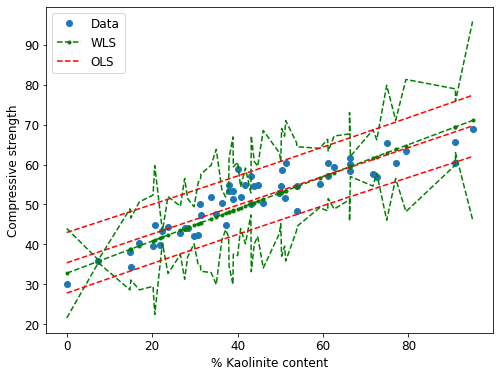

In [7]:
for i in [1,3,7,28,90]:
    compute_WLS_model(data, i, summary=True, plot=True, show_bounds=True, show_ols=True)

Now we will try it again but applying the variance as weight instead of the standard deviation. This is instead of inputting as weights the STD_1D, STD_3D, etc.; we will input the STD_1D^2, STD_3D^2, etc.

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            WLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.563
Date:                Mon, 14 Dec 2020   Prob (F-statistic):              0.216
Time:                        04:15:02   Log-Likelihood:                -180.86
No. Observations:                  66   AIC:                             365.7
Df Residuals:                      64   BIC:                             370.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6771      0.166     70.440      0.0

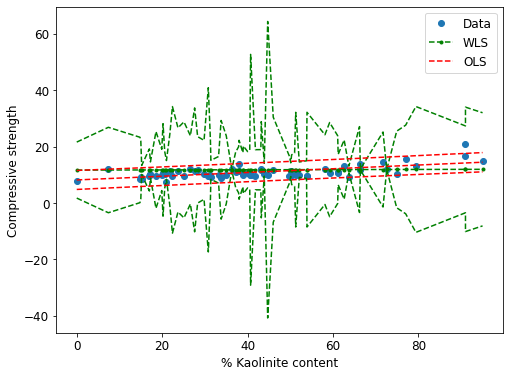

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.983
Model:                            WLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     3632.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           4.27e-58
Time:                        04:15:02   Log-Likelihood:                -252.46
No. Observations:                  66   AIC:                             508.9
Df Residuals:                      64   BIC:                             513.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.8515      0.179     88.419      0.0

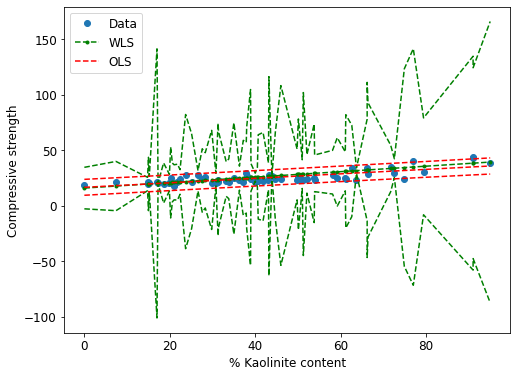

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.983
Model:                            WLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     3638.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           4.06e-58
Time:                        04:15:02   Log-Likelihood:                -216.62
No. Observations:                  66   AIC:                             437.2
Df Residuals:                      64   BIC:                             441.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.4950      0.070    379.483      0.0

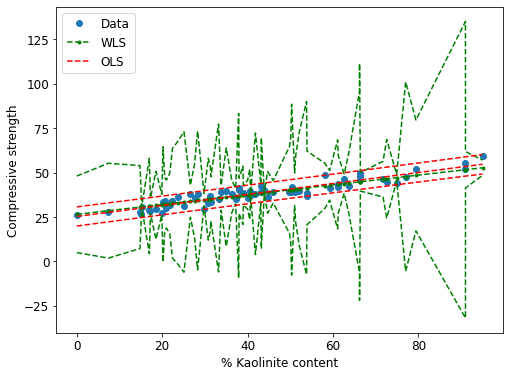

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.977
Model:                            WLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2661.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           7.38e-54
Time:                        04:15:03   Log-Likelihood:                -281.20
No. Observations:                  66   AIC:                             566.4
Df Residuals:                      64   BIC:                             570.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.7845      0.171    173.999      0.0

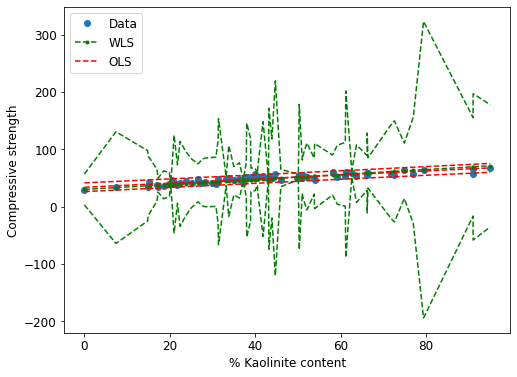

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            WLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3290.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           2.21e-49
Time:                        04:15:03   Log-Likelihood:                -196.99
No. Observations:                  55   AIC:                             398.0
Df Residuals:                      53   BIC:                             402.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.5000      0.057    571.603      0.0

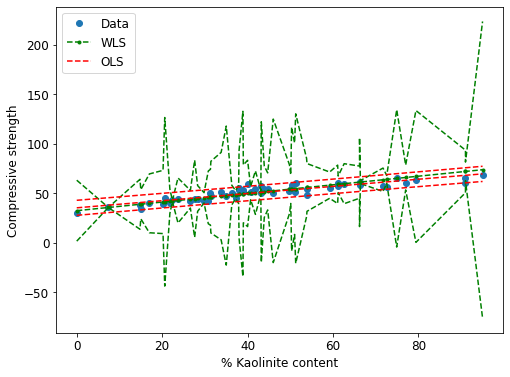

In [8]:
for i in [1,3,7,28,90]:
    compute_WLS_model(data, i, summary=True, plot=True, show_bounds=True, show_ols=True, weights2 = True)

It is less accurate to put the inverse variance instead of the inverse standard deviation as we obtain exorbitant values. Let's make a comparison of the days taking into account the standard deviation only. But first let's remove the datapoints with a very large standard deviation.

In [9]:
## subplots de todos los días aquí
# data without outliers

data_wo_ol = data[(data["STD_1D"]<4) | (data["STD_3D"]<4) | (data["STD_7D"]<4) | (data["STD_28D"]<4) | (data["STD_90D"]<4) ]
data_wo_ol

,Clay,day_1,STD_1D,day_3,STD_3D,day_7,STD_7D,day_28,STD_28D,day_90,...,CaO,MgO,SO3,Na2O,K2O,TiO2,P2O5,MnO,Others,LOI
0,B45 Quartz B250,7.808750,0.251891,18.683750,0.328841,26.073438,0.696464,29.168750,0.541867,30.062500,...,NaN,NaN,NaN,NaN,0.100000,NaN,NaN,NaN,NaN,0.10000
44,Iran G2,11.934375,0.384489,21.492282,0.384489,27.876247,0.861786,34.715457,1.842897,35.720665,...,0.527174,0.467391,0.197826,1.107609,3.463043,1.652174,0.755435,NaN,0.760870,0.73913
19,Holcim 3 U.S.,8.479688,0.294320,20.914062,0.126797,28.031250,0.754776,36.659375,1.178679,38.145313,...,7.719000,2.641000,0.576000,0.370000,2.637000,0.631000,0.224000,NaN,0.160000,1.04000
13,South Africa,9.387500,0.260358,19.310938,0.414056,26.745313,0.406823,33.459375,0.971274,34.284375,...,0.055000,1.126000,NaN,0.556000,3.785000,0.920000,NaN,NaN,NaN,3.76000
57,Guat 4,8.459375,0.039775,19.987500,0.141421,30.690625,0.004419,42.446875,0.950175,NaN,...,2.574358,2.452426,0.020145,1.559671,1.673121,0.995602,0.117691,0.173886,0.004241,1.20000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,Newchem,15.739062,0.398806,40.104687,1.729149,47.618750,1.716381,56.648438,1.757376,60.450000,...,NaN,0.070000,NaN,0.090000,NaN,1.803000,NaN,NaN,0.100000,1.00000
5,B45 India1 750°C,13.183750,0.566334,30.173750,0.726647,52.091250,1.006780,64.031250,4.819113,63.318750,...,0.100000,0.100000,NaN,0.100000,0.100000,2.400000,0.100000,NaN,0.200000,1.00000
10,Imerys 3%,20.751562,0.390925,42.773438,1.566299,55.651562,2.685301,65.831250,1.629377,65.610417,...,NaN,NaN,NaN,NaN,0.060000,2.278000,NaN,NaN,NaN,2.02000
11,Imerys 2%,16.714063,0.560096,43.670313,1.400933,51.946875,0.332701,57.267187,2.402090,60.501562,...,NaN,NaN,NaN,NaN,0.060000,2.278000,NaN,NaN,NaN,2.02000


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            WLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1487.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           1.85e-40
Time:                        04:15:04   Log-Likelihood:                -156.56
No. Observations:                  55   AIC:                             317.1
Df Residuals:                      53   BIC:                             321.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.7903      0.160    205.104      0.0

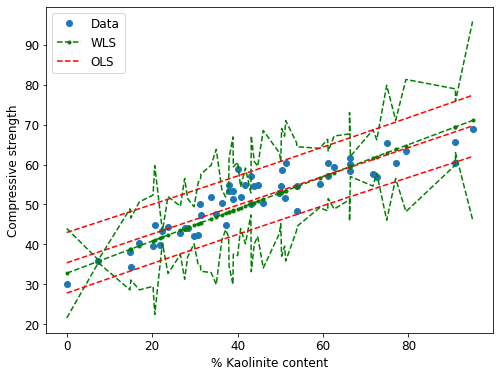

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            WLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1487.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           1.85e-40
Time:                        04:15:04   Log-Likelihood:                -156.56
No. Observations:                  55   AIC:                             317.1
Df Residuals:                      53   BIC:                             321.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.7903      0.160    205.104      0.0

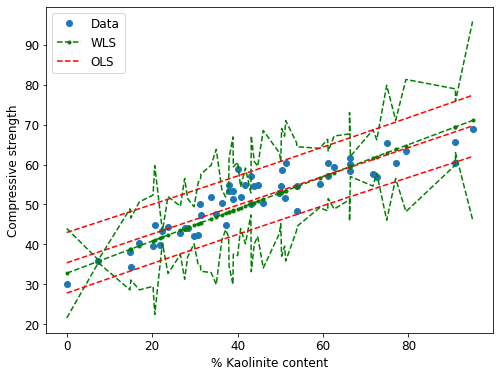

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            WLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1487.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           1.85e-40
Time:                        04:15:05   Log-Likelihood:                -156.56
No. Observations:                  55   AIC:                             317.1
Df Residuals:                      53   BIC:                             321.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.7903      0.160    205.104      0.0

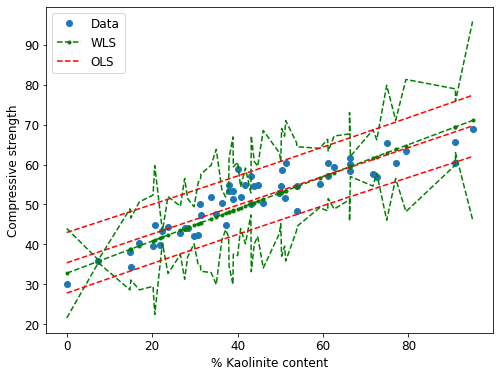

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            WLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1487.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           1.85e-40
Time:                        04:15:05   Log-Likelihood:                -156.56
No. Observations:                  55   AIC:                             317.1
Df Residuals:                      53   BIC:                             321.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.7903      0.160    205.104      0.0

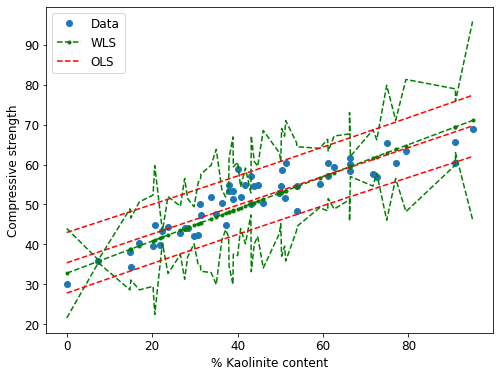

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.966
Model:                            WLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1487.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           1.85e-40
Time:                        04:15:05   Log-Likelihood:                -156.56
No. Observations:                  55   AIC:                             317.1
Df Residuals:                      53   BIC:                             321.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.7903      0.160    205.104      0.0

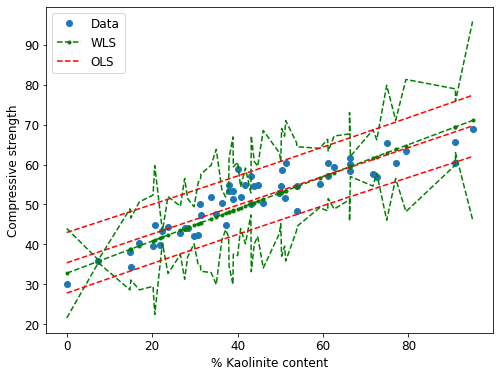

In [10]:
# WLS model for days 1, 3, 7, 28, and 90 for data without outliers
for day in [1,3,7,28,90]:
    compute_WLS_model(data, i, summary=True, plot=True, show_bounds=True, show_ols=True)

# Modelling STD only

We will try to see if there is a relation and with which values in the STDs given by the first proposed dataset.

In [12]:
def create_name_and_formula(day, variables):
    name = f"STD_{i}D_{len(variables)}vars_"+"_".join(variables)
    formula = f"STD_{day}D ~ "
    equals = "+".join(variables)
    return [name, formula+equals]

def get_model_r2_adj(formula, df):
    mods = smf.ols(formula=formula, data=df)
    res = mods.fit()
    return res.rsquared_adj

def get_model(day, variables, df):
    name, formula = create_name_and_formula(day, variables)
    df_nmv = df.copy()
    varrr = [f"STD_{day}D"] + variables
    df_nmv = df_nmv[varrr]
    df_nmv = df_nmv.dropna()
    df_nmv = (df_nmv-df_nmv.min())/(df_nmv.max()-df_nmv.min())
    mods = smf.ols(formula=formula, data=df_nmv)
    res = mods.fit()
    return mods, res

In [13]:
data.columns

Index(['Clay', 'day_1', 'STD_1D', 'day_3', 'STD_3D', 'day_7', 'STD_7D',
       'day_28', 'STD_28D', 'day_90', 'STD_90D', 'Origin of clay',
       'Calcination', 'Kaolinite_content', 'Dv50', 'D10', 'D90', 'Span (-)',
       'BET_specific_surface', 'SiO2', 'Al2O3', 'Fe2O3', 'CaO', 'MgO', 'SO3',
       'Na2O', 'K2O', 'TiO2', 'P2O5', 'MnO', 'Others', 'LOI'],
      dtype='object')

In [14]:
data_clean = data[['Kaolinite_content', 'Dv50', 'BET_specific_surface', 'Al2O3', 'Fe2O3', 'CaO', 'MgO', 'K2O', 'TiO2']]

In [15]:
cols = data_clean.columns.values

bestAdjR2s = {}
bestCombs = {}

# Max number of variables for the model
maxnvars = len(cols)

# Try all combinations
for i in [1, 3, 7, 28, 90]:
    bestAdjR2 = -1
    bestComb = ''
    # Try combinations of 1, 2, ..., maxnvars variables
    for j in range(1,maxnvars+1):
        for vararr in combinations(cols, j):
            df_nmv = data.copy()
            varrr = [f"STD_{i}D"] + list(vararr)
            df_nmv = df_nmv[varrr]
            df_nmv = df_nmv.dropna()
            df_nmv = (df_nmv-df_nmv.min())/(df_nmv.max()-df_nmv.min())
            name, formula = create_name_and_formula(i, vararr)
            r2 = get_model_r2_adj(formula, df_nmv)
            if(r2>bestAdjR2): 
                bestAdjR2 = r2
                bestComb = name
            #print(formula+":"+str(r2))
    bestAdjR2s[f"STD_{i}D"] = bestAdjR2
    bestCombs[f"STD_{i}D"]= bestComb

bestAdjR2s, bestCombs

({'STD_1D': 0.2895281031117908,
  'STD_3D': 0.20176383511662765,
  'STD_7D': 0.16730527157579078,
  'STD_28D': 0.18968605412491657,
  'STD_90D': 0.13896299546699586},
 {'STD_1D': 'STD_1D_8vars_Kaolinite_content_Dv50_BET_specific_surface_Al2O3_Fe2O3_CaO_MgO_TiO2',
  'STD_3D': 'STD_3D_1vars_Kaolinite_content',
  'STD_7D': 'STD_7D_3vars_Dv50_BET_specific_surface_TiO2',
  'STD_28D': 'STD_28D_4vars_Dv50_BET_specific_surface_Al2O3_TiO2',
  'STD_90D': 'STD_90D_5vars_Dv50_BET_specific_surface_Fe2O3_CaO_K2O'})

We can see that the maximum adjusted R squared is 0.2895. However, this happens when we model the data with 8 variables. This is probably overfitting even if the adjusted R-squared is penalizing the use of more variables. Additionally, we can appriciate how, the score decreases with the time. This makes sense since we have less datapoints for those days. For this reason, because this method does not give us a lot of information, we can deduce that there is not a way to model with a linear model. 
That said, we can appreciate a larger influence of Kaolinite content in the standard deviation for during the first dates. After that the "Dv50", "BET_specific_surface", and "TiO2" are the ones that appear in almost every model.

Let's see what happens when we limit the combinations to 3 variables as a way to get a more robust model and avoid overfitting. 

In [16]:
# Max number of variables for the model
maxnvars = 3

# Try all combinations
for i in [1, 3, 7, 28, 90]:
    bestAdjR2 = -1
    bestComb = ''
    # Try combinations of 1, 2, ..., maxnvars variables
    for j in range(1,maxnvars+1):
        for vararr in combinations(cols, j):
            df_nmv = data.copy()
            varrr = [f"STD_{i}D"] + list(vararr)
            df_nmv = df_nmv[varrr]
            df_nmv = df_nmv.dropna()
            df_nmv = (df_nmv-df_nmv.min())/(df_nmv.max()-df_nmv.min())
            name, formula = create_name_and_formula(i, vararr)
            r2 = get_model_r2_adj(formula, df_nmv)
            if(r2>bestAdjR2): 
                bestAdjR2 = r2
                bestComb = name
            #print(formula+":"+str(r2))
    bestAdjR2s[f"STD_{i}D"] = bestAdjR2
    bestCombs[f"STD_{i}D"]= bestComb

bestAdjR2s, bestCombs

({'STD_1D': 0.15473110489958197,
  'STD_3D': 0.20176383511662765,
  'STD_7D': 0.16730527157579078,
  'STD_28D': 0.18739708007225597,
  'STD_90D': 0.10656429445897586},
 {'STD_1D': 'STD_1D_3vars_BET_specific_surface_CaO_TiO2',
  'STD_3D': 'STD_3D_1vars_Kaolinite_content',
  'STD_7D': 'STD_7D_3vars_Dv50_BET_specific_surface_TiO2',
  'STD_28D': 'STD_28D_3vars_Kaolinite_content_Dv50_BET_specific_surface',
  'STD_90D': 'STD_90D_2vars_CaO_K2O'})

As espected we get a lower but more realistic score. This confirms that, in general, the r-squared is too low to take it into account. 

We could try to plot them results to see if it follows another kind of nonlinear model.

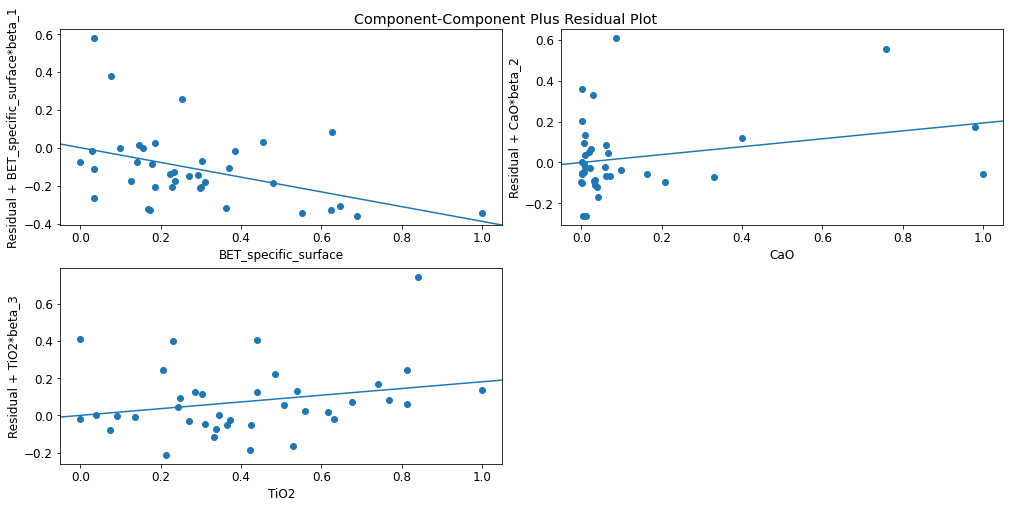

In [17]:
# STD_1D_3vars_BET_specific_surface_CaO_TiO2
features_1D = ["BET_specific_surface", "CaO", "TiO2"]

mod_1D, res_1D = get_model(1, features_1D, data)

fig_1D = sm.graphics.plot_ccpr_grid(res_1D)
fig_1D.tight_layout(pad=0.5)

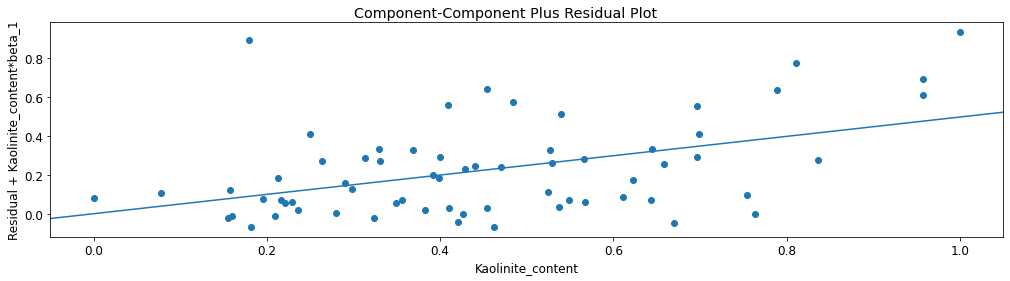

In [18]:
# STD_3D_1vars_Kaolinite_content
features_3D = ["Kaolinite_content"]

mod_3D, res_3D = get_model(3, features_3D, data)

fig_3D = sm.graphics.plot_ccpr_grid(res_3D)
fig_3D.tight_layout(pad=0.5)

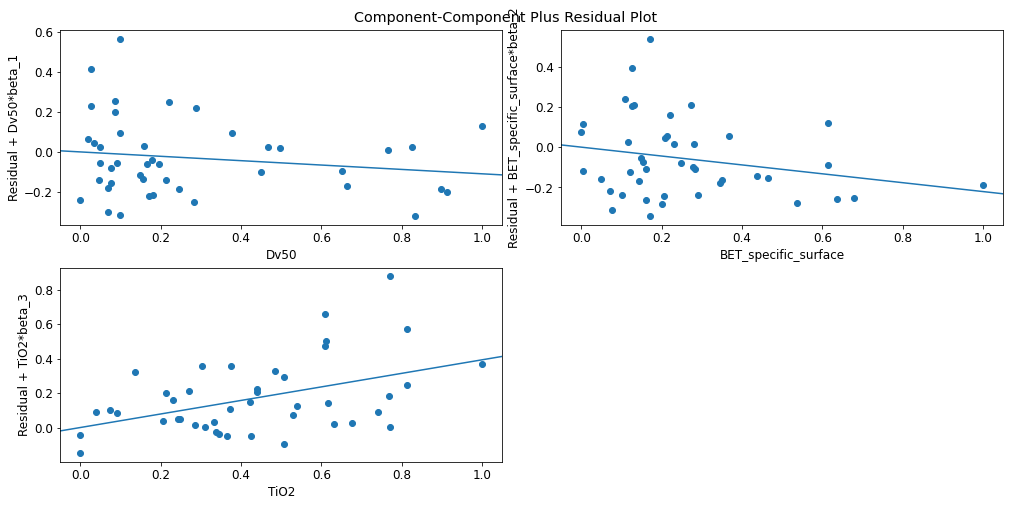

In [19]:
# STD_7D_3vars_Dv50_BET_specific_surface_TiO2
features_7D = ["Dv50", "BET_specific_surface", "TiO2"]

mod_7D, res_7D = get_model(7, features_7D, data)

fig_7D = sm.graphics.plot_ccpr_grid(res_7D)
fig_7D.tight_layout(pad=0.5)

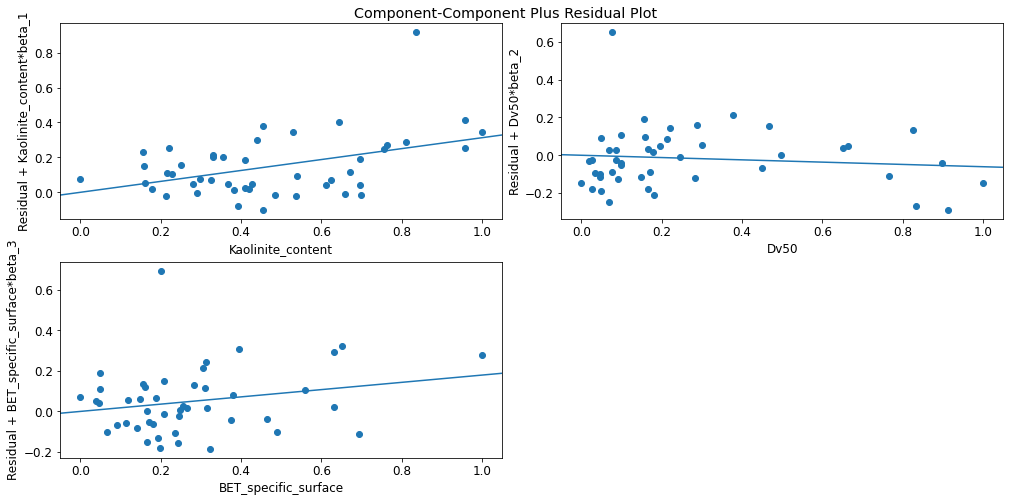

In [20]:
# 'STD_28D': 'STD_28D_3vars_Kaolinite_content_Dv50_BET_specific_surface',
features_28D = ["Kaolinite_content", "Dv50", "BET_specific_surface"]

mod_28D, res_28D = get_model(28, features_28D, data)

fig_28D = sm.graphics.plot_ccpr_grid(res_28D)
fig_28D.tight_layout(pad=0.5)

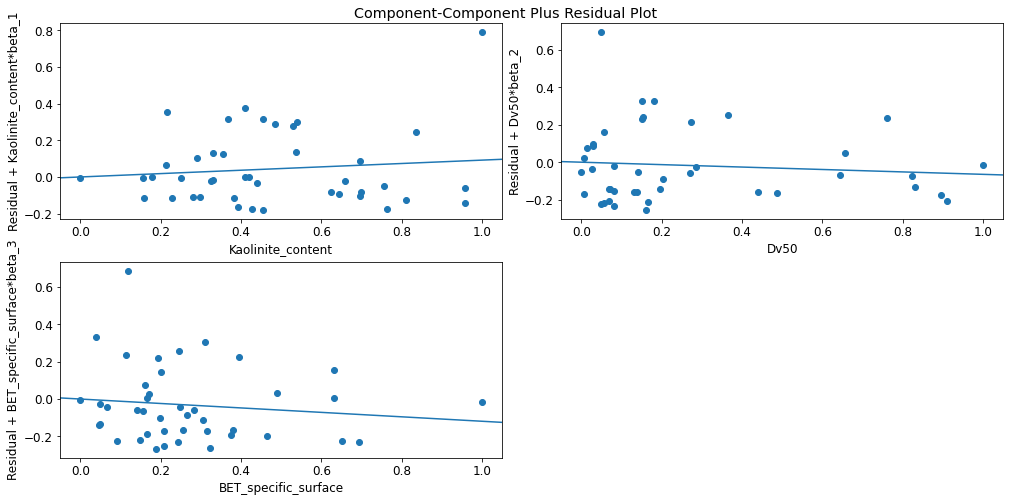

In [21]:
# 'STD_90D': 'STD_90D_2vars_CaO_K2O'
features_90D = ["Kaolinite_content", "Dv50", "BET_specific_surface"]

mod_90D, res_90D = get_model(90, features_90D, data)

fig_90D = sm.graphics.plot_ccpr_grid(res_90D)
fig_90D.tight_layout(pad=0.5)

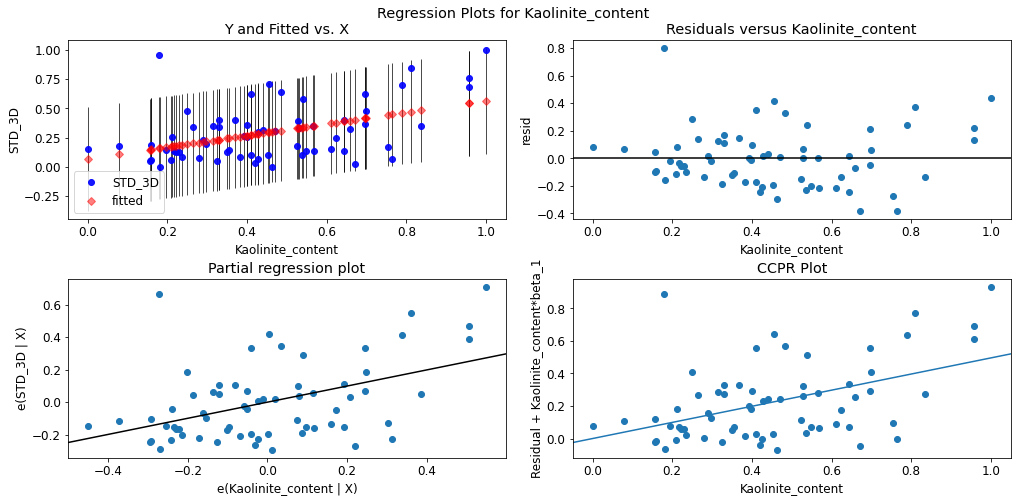

In [22]:
# To visualize more information on day 3 (only one variable) let's 
# build more possibly valuable and informative plots

fig_3D_bis = sm.graphics.plot_regress_exog(res_3D, "Kaolinite_content")
fig_3D_bis.tight_layout(pad=0.5)

This 2x2 plot contains the dependent variable and fitted values with confidence intervals vs. the independent variable chosen, the residuals of the model vs. the chosen independent variable, a partial regression plot, and a CCPR plot. *This function can be used for quickly checking modeling assumptions with respect to a single regressor.* [1]


No day does seems to be following any polynomial trajectory
Another approach we could carry out would be to model the data taking the "days" as variables.

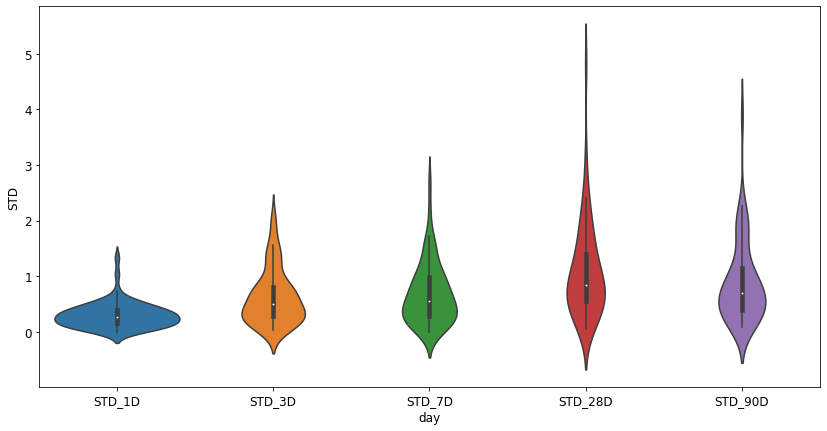

In [23]:
melted_data = pd.melt(data, id_vars=['Clay'], value_vars=['STD_1D','STD_3D','STD_7D','STD_28D','STD_90D'], var_name='day', value_name='STD')
ax = sns.violinplot(x="day", y="STD", data=melted_data)
#plt.plot

<AxesSubplot:>

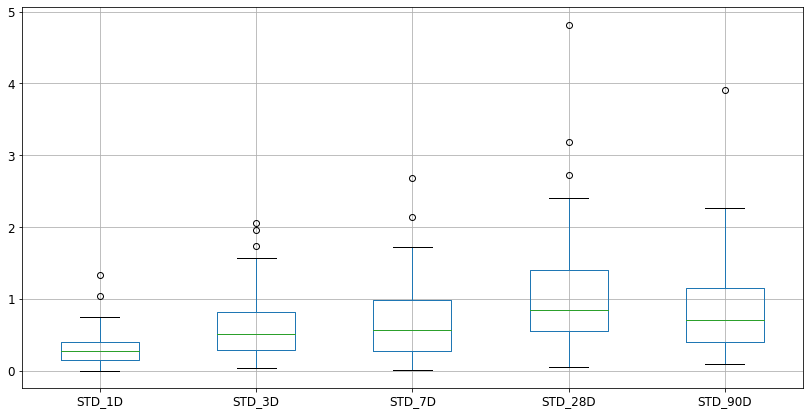

In [24]:
# If we plot it with boxplots we will see the outliers with more detail

data.boxplot(column=['STD_1D', 'STD_3D', 'STD_7D', 'STD_28D', 'STD_90D'])

Can we create a model with 7 values?

In [25]:
data_quantiles = melted_data.copy()
data_quantiles["days"] = np.zeros(330)
data_quantiles["days"][data_quantiles["day"]=="STD_1D"] = 1
data_quantiles["days"][data_quantiles["day"]=="STD_3D"] = 3
data_quantiles["days"][data_quantiles["day"]=="STD_7D"] = 7
data_quantiles["days"][data_quantiles["day"]=="STD_28D"] = 28
data_quantiles["days"][data_quantiles["day"]=="STD_90D"] = 90
data_quantiles

,Clay,day,STD,days
0,B45 Quartz B250,STD_1D,0.251891,1.0
1,Iran G2,STD_1D,0.384489,1.0
2,Holcim 3 U.S.,STD_1D,0.294320,1.0
3,South Africa,STD_1D,0.260358,1.0
4,Guat 4,STD_1D,0.039775,1.0
...,...,...,...,...
325,Newchem,STD_90D,0.407402,90.0
326,B45 India1 750°C,STD_90D,1.785445,90.0
327,Imerys 3%,STD_90D,0.635362,90.0
328,Imerys 2%,STD_90D,0.327529,90.0


In [26]:
mod = smf.quantreg('STD ~ days', data_quantiles)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    STD   Pseudo R-squared:              0.03568
Model:                       QuantReg   Bandwidth:                      0.3513
Method:                 Least Squares   Sparsity:                        1.128
Date:                Mon, 14 Dec 2020   No. Observations:                  319
Time:                        04:09:27   Df Residuals:                      317
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4143      0.039     10.546      0.000       0.337       0.492
days           0.0046      0.001      4.595      0.000       0.003       0.007


In [27]:
# Visualizing Quantiles
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['days']] + res.conf_int().loc['days'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

ols = smf.ols('STD ~ days', data_quantiles).fit()
ols_ci = ols.conf_int().loc['days'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['days'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

      q         a         b        lb        ub
0  0.05  0.052227  0.000746 -0.000494  0.001987
1  0.15  0.148172  0.001861  0.000396  0.003325
2  0.25  0.211429  0.002319  0.000672  0.003966
3  0.35  0.299236  0.003374  0.001635  0.005114
4  0.45  0.377770  0.004150  0.002253  0.006048
5  0.55  0.492285  0.003925  0.001811  0.006040
6  0.65  0.636647  0.004936  0.002296  0.007576
7  0.75  0.731880  0.009373  0.006215  0.012532
8  0.85  1.053427  0.009413  0.005230  0.013596
9  0.95  1.661839  0.007791  0.003405  0.012178
{'a': 0.5965832569853864, 'b': 0.004583669904234722, 'lb': 0.002397946311163071, 'ub': 0.0067693934973063735}


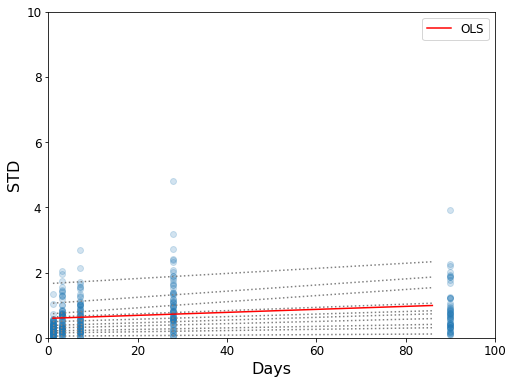

In [28]:
x = np.arange(data_quantiles.days.min(), data_quantiles.days.max(), 85)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')

y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(data_quantiles.days, data_quantiles.STD, alpha=.2)
ax.set_xlim((0, 100))
ax.set_ylim((0, 10))
legend = ax.legend()
ax.set_xlabel('Days', fontsize=16)
ax.set_ylabel('STD', fontsize=16);

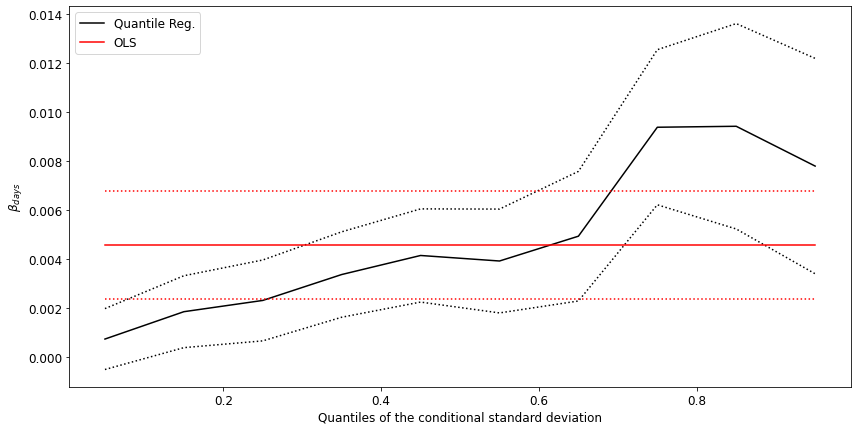

In [29]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{days}$')
plt.xlabel('Quantiles of the conditional standard deviation')
plt.legend()
plt.show()

### References:


[1] https://www.statsmodels.org/devel/examples

[2] [Wikipedia - Weighted Least Squares](https://en.wikipedia.org/wiki/Weighted_least_squares#:~:text=Weighted%20least%20squares%20(WLS)%2C,different%20from%20an%20identity%20matrix)